# Homework 4: Natural Language Processing

**Overview**: In this homework you will be working with the Amazon Reviews Dataset. This dataset contains hundreds of thousands of reviews, each with it's raw text, it's summary and a score from 1-5 on the rating corresponding to the review. In this assignment you will be creating a multitude of discriminative models to classify the rating from the text of the review, from simple non-deep learning baseline approaches to creating multiple different deep recurrent neural networks, using attention and transfer learning to boost classfication accuracy. Past that, you will create a generative model to generate summaries of a given review from scratch!


**Collaboration Policy:** This homework assignment is meant to be done in **groups of 2**. You may work on this individually, but be warned that this homework assignment is long and will be difficult to do alone. We highly recommend you form groups. Since this is a group assignment, please read over the collaboration policy again, posted [here](https://www.seas.upenn.edu/~cis522/syllabus.html).



# Q0. Setting up (0 pts)

## Connect to Google Drive

Run the code snippet below to connect to Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Utility Functions

The function below is a utility function for plotting Confusion Matrices. We highly recommend that you use it for your analysis, but if you have an easier way of plotting confusion matrices / would like to do it yourself, feel free to do so instead.

In [0]:
from textwrap import wrap
import re
import itertools
import matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix


# Credits - https://stackoverflow.com/questions/41617463/tensorflow-confusion-matrix-in-tensorboard
def plot_confusion_matrix(correct_labels, predict_labels, labels, display_labels, title='Confusion matrix', tensor_name = 'MyFigure/image', normalize=False):
  ''' 
  Parameters:
      correct_labels           : These are your true classification categories.
      predict_labels           : These are you predicted classification categories
      labels               : This is a lit of labels which will be used to display the axis labels
      title='Confusion matrix'        : Title for your matrix
      tensor_name = 'MyFigure/image'  : Name for the output summay tensor

  Returns:
      summary: TensorFlow summary 

  Other items to note:
      - Depending on the number of category and the data , you may have to modify the figzie, font sizes etc. 
      - Currently, some of the ticks dont line up due to rotations.
  '''
  cm = confusion_matrix(correct_labels, predict_labels, labels=labels)
  if normalize:
      cm = cm.astype('float')*10 / cm.sum(axis=1)[:, np.newaxis]
      cm = np.nan_to_num(cm, copy=True)
      cm = cm.astype('int')

  np.set_printoptions(precision=2)
  ###fig, ax = matplotlib.figure.Figure()

  fig = matplotlib.pyplot.figure(figsize=(2, 2), dpi=320, facecolor='w', edgecolor='k')
  ax = fig.add_subplot(1, 1, 1)
  im = ax.imshow(cm, cmap='Oranges')

  classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in display_labels]
  classes = ['\n'.join(wrap(l, 40)) for l in classes]

  tick_marks = np.arange(len(classes))

  ax.set_xlabel('Predicted', fontsize=7)
  ax.set_xticks(tick_marks)
  c = ax.set_xticklabels(classes, fontsize=4, rotation=-90,  ha='center')
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  ax.set_ylabel('True Label', fontsize=7)
  ax.set_yticks(tick_marks)
  ax.set_yticklabels(classes, fontsize=4, va ='center')
  ax.yaxis.set_label_position('left')
  ax.yaxis.tick_left()

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      ax.text(j, i, format(cm[i, j], 'd') if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color= "black")
  fig.set_tight_layout(True)
  matplotlib.pyplot.show()

  return

### Test Infrastructure

Run the two code snippets below to instantiate our infrastructure for this assignment.

In [0]:
import os
import dill
import pandas as pd

repo_path = "/content/Homework4_Resources/test_release.csv"

if not os.path.isdir(repo_path):
  !git clone https://github.com/CIS522/Homework4_Resources.git

def generate_test_predictions(generate_predictions_func):
  return generate_predictions_func(repo_path)

Cloning into 'Homework4_Resources'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15 (delta 1), reused 5 (delta 1), pack-reused 9
Unpacking objects: 100% (15/15), done.


In [0]:
test_case_1b        = None
test_case_1c        = None
test_case_3e_rnn      = None
test_case_3e_lstm      = None
test_case_3e_gru      = None
test_case_3e_bilstm     = None
test_case_4e        = None
test_case_5b        = None

# Data Loading and Pre-processing

In this assignment, you'll be working with the Amazon Reviews Dataset. We've provided you with the train / validate splits. In the code cell below, load in the splits using Pandas.

## Load Splits

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [0]:
# TODO: INSERT CODE HERE
root_path = '/content/drive/My Drive/CIS522 Homeworks/HW4/'
train = pd.read_csv(root_path + 'train.csv')
val = pd.read_csv(root_path + 'val.csv')

# Q1. Baseline (15 pts)

For any deep learning task, it's good to have a baseline approach to compare against so you can determine if your deep learning approach is truly doing anything extraordinary, or in some cases, is even worse than simpler approaches. In this question we will have you implement a very simple baseline approach for classifying Amazon Reviews.

**Baselines** You will be implementing two simple baseline approaches:

*Approach 1:* For each sentence, process each word individually and note whether it is positive or negative. You will calculate the ratio of positive words to positive + negative words in the sentence, and threshold it to get a prediction between 1-5 of the review's star rating. 

*Approach 2:* In this approach you will feed in the number of positive and negative words in each sentence into a logistic regression classifier to get a classification between 1-5.



## Q1a Processing the Data

Before implementing the baselines, you must first process the data! Look through the Amazon Reviews dataset and consider the headers. For this question, all you will need are the "Text" and "Score" fields. 

Before we process the data, we must note two things:

**How do we get the connotation?** To determine if a word has a "positive" or a "negative" connotation we will be using the [MPQA subjectivity lexicon](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/) (which we've provided to you as a .tff file in this assignment). If you open the .tff file in a text editor, you'll see that each line has the word, preceded by "word1=" and a polarity of the form "priorpolarity=negative" for a negatively connoted word for instance. You should parse the tff file to create a dictionary that goes from word to it's polarity (positive or negative)

**How do we handle different forms of words?** In this tff file, we note that there's a lot of words, but how do we account for different forms of words? For instance, how do we account for the plural form of a noun, or a different conjugation of a verb? In NLP it is very common to account for this by "lemmatizing" a word, which essentially means to convert words to a "base" form so they can be analyzed more easily. In this classification task, this is useful since we don't care about how a word is conjugated, just what the connotation of a word is.

**Q1a (1 pts):** In this question, create a dictionary from the .tff file such that the keys are the lemmatized forms of the word, and the value is the polarity of the word (if the word is positive, let its value be 1, if it's negative let it be 0). We've initialized NLTK and specifically the lemmatizer for you below. Do ```lemmatizer.lemmatize(word)``` to lemmatize a specific word. In your writeup, give three examples of words which are different than their lemmatized forms (i.e. are not the exact same text).



In [0]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('punkt') # Download this as this allows you to tokenize words in a string.
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
with open (root_path+'MPQA_Subjectivity_Lexicon.tff', 'r') as file:
  f = file.readlines()

polarity = {}
example = {}
for i,s in enumerate(f):
  start1, start2 = s.find('word1=')+6, s.find('priorpolarity=')+14
  len1, len2 = s[start1:].find(' '), s[start2:].find('\n')
  word, pol = s[start1:start1+len1], s[start2:start2+len2]
  lem = lemmatizer.lemmatize(word)
  if lem != word: example[word] = lem
  polarity[lem] = int(pol=='positive')

In [0]:
example

{'abilities': 'ability',
 'abuses': 'abuse',
 'accolades': 'accolade',
 'accomplishments': 'accomplishment',
 'accusations': 'accusation',
 'achievements': 'achievement',
 'adolescents': 'adolescent',
 'advantages': 'advantage',
 'agonies': 'agony',
 'airs': 'air',
 'alas': 'ala',
 'allegations': 'allegation',
 'alliances': 'alliance',
 'allusions': 'allusion',
 'anxieties': 'anxiety',
 'apologists': 'apologist',
 'apprehensions': 'apprehension',
 'arguments': 'argument',
 'aspersions': 'aspersion',
 'aspirations': 'aspiration',
 'assertions': 'assertion',
 'assess': 'ass',
 'assessments': 'assessment',
 'assurances': 'assurance',
 'atrocities': 'atrocity',
 'attitudes': 'attitude',
 'batons': 'baton',
 'beliefs': 'belief',
 'benefits': 'benefit',
 'betrayals': 'betrayal',
 'biases': 'bias',
 'blunders': 'blunder',
 'brains': 'brain',
 'breakthroughs': 'breakthrough',
 'brutalities': 'brutality',
 'bullies': 'bully',
 'calamities': 'calamity',
 'calumnies': 'calumny',
 'catastrophes': 

**Thresholding Baseline**

Now that you've created this dictionary, go through your training dataset and for each review, compute the following ratio: $$ratio = \frac{positive}{positive + negative}$$ Where $positive$ is the number of words with positive polarity in the review, and $negative$ is the number of words with negative polarity in the review. 

**Notes:** You can tokenize the text into individual words by using ```nltk.word_tokenize(text)```. Don't forget to lemmatize each word as well! You can treat any word not in the MPQA subjectivity lexicon as having a neutral sentiment. For the case where $positive + negative = 0$ feel free to handle it however you like (i.e. always have it predict a certain class, etc.). Describe how you handled this in your writeup for **Q1d**.

**Q1b (2 pts; 2 pts autograder):** Using the validation set, create a series of thresholds such that you can threshold this ratio to produce your review predictions between 1 and 5. Calculate the F1 score of your predictions versus the ground truth scores (setting average to **macro**). You may use SkLearn to calculate the F1 Score. In your writeup, describe how you chose these thresholds and what the resulting macro average F1 Score is for your training set and validation set.

In [0]:
# TODO: INSERT CODE HERE
def ratio(s):
  '''
  compute the ratio of a sentence, i.e. positive/(positive + negative)
  '''
  s = nltk.word_tokenize(s)
  pos, neg = 0, 0
  for w in s:
    lem = lemmatizer.lemmatize(w)
    if lem in polarity: pol = polarity[lem]
    else: pol = 0.5
    if pol==1: pos += 1
    else: neg += 1
  if pos+neg == 0: return 0.5
  else: return pos/(pos+neg), pos, neg

In [0]:
# compute the ratio of each review for training set
train['Ratio'], train['pos_neg'] = None, None
for i in range(len(train)):
  ro, pos, neg = ratio(train['Text'][i])
  train['Ratio'][i], train['pos_neg'][i] = ro, (pos, neg)

# compute the ratio of each review for validation set
val['Ratio'], val['pos_neg'] = None, None
for i in range(len(val)):
  ro, pos, neg = ratio(val['Text'][i])
  val['Ratio'][i], val['pos_neg'][i] = ro, (pos, neg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [0]:
# pick the threshhold for 5 scores
ratio_at_score_1 = train[train['Score']==1]['Ratio']
ratio_at_score_2 = train[train['Score']==2]['Ratio']
ratio_at_score_3 = train[train['Score']==3]['Ratio']
ratio_at_score_4 = train[train['Score']==4]['Ratio']
ratio_at_score_5 = train[train['Score']==5]['Ratio']

mean1, min1, max1 = np.mean(ratio_at_score_1), min(ratio_at_score_1), max(ratio_at_score_1)
mean2, min2, max2 = np.mean(ratio_at_score_2), min(ratio_at_score_2), max(ratio_at_score_2)
mean3, min3, max3 = np.mean(ratio_at_score_3), min(ratio_at_score_3), max(ratio_at_score_3)
mean4, min4, max4 = np.mean(ratio_at_score_4), min(ratio_at_score_4), max(ratio_at_score_4)
mean5, min5, max5 = np.mean(ratio_at_score_5), min(ratio_at_score_5), max(ratio_at_score_5)
print(f'score 1: {mean1}, {min1}, {max1}')
print(f'score 2: {mean2}, {min2}, {max2}')
print(f'score 3: {mean3}, {min3}, {max3}')
print(f'score 4: {mean4}, {min4}, {max4}')
print(f'score 5: {mean5}, {min5}, {max5}')

thresh12, thresh23, thresh34, thresh45 = np.mean([mean1,mean2]), np.mean([mean2,mean3]), np.mean([mean3,mean4]), np.mean([mean4,mean5])

score 1: 0.044782446100595376, 0.0, 0.25806451612903225
score 2: 0.05259048742877389, 0.0, 0.25
score 3: 0.05842466710367438, 0.0, 0.3157894736842105
score 4: 0.06882937352990744, 0.0, 0.35
score 5: 0.07387895825144376, 0.0, 0.5416666666666666


In [0]:
def classify(v):
  '''
  Predict score according to the ratio and the threshold
  '''
  if v <= thresh12: return 1
  elif v <= thresh23: return 2
  elif v <= thresh34: return 3
  elif v <= thresh45: return 4
  else: return 5

In [0]:
# predict the score for training set
train['Predict'] = None
for i in range(len(train)):
  train['Predict'][i] = classify(train['Ratio'][i])

# predict the score for validation set
val['Predict'] = None
for i in range(len(val)):
  val['Predict'][i] = classify(val['Ratio'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
F1_train = f1_score(list(train['Score']), list(train['Predict']), average='macro')
F1_val = f1_score(list(val['Score']), list(val['Predict']), average='macro')
print('F1-Score for training set: {:.4f} \nF1-Score for validation set: {:.4f}'.format(F1_train, F1_val))

F1-Score for training set: 0.2244 
F1-Score for validation set: 0.2334


**Q1c (3 pts; 3pts autograder):** Now, train a logistic regression classifier, where the inputs to the logistic regression classifier are the number of positively and negatively connoted words in the sentence. Tune the hyperparameters using the validation set. Create a test set from the training set, train the logistic regression using the hyperparameters obtained from tuning on the validation set, and then report your test, training, and validation set macro-averaged F1 Scores in your writeup. Discuss how you tuned hyperparameters in your writeup.

In [0]:
# TODO: INSERT CODE HERE
test_sub, train_sub = train_test_split(train, test_size=0.3)
model_lr = LogisticRegression(solver='saga', max_iter=300)
model_lr.fit(list(train_sub['pos_neg']), list(train_sub['Score']))

F1_train_sub = f1_score(list(train_sub['Score']), model_lr.predict(list(train_sub['pos_neg'])), average='macro')
F1_val_sub = f1_score(list(val['Score']), model_lr.predict(list(val['pos_neg'])), average='macro')
F1_test_sub = f1_score(list(test_sub['Score']), model_lr.predict(list(test_sub['pos_neg'])), average='macro')
print('F1-Score for training set: {:.4f} \nF1-Score for validation set: {:.4f} \nF1-Score for test set: {:.4f}'.format(F1_train_sub, F1_val_sub, F1_test_sub))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


F1-Score for training set: 0.1759 
F1-Score for validation set: 0.0868 
F1-Score for test set: 0.1748


**Q1d (4 pts):** Compare the results from the logistic regression baseline and the thresholding baseline. Plot a confusion matrix for both and compare the results / put the confusion matrices in the writeup (feel free to use the utility function we provided above).

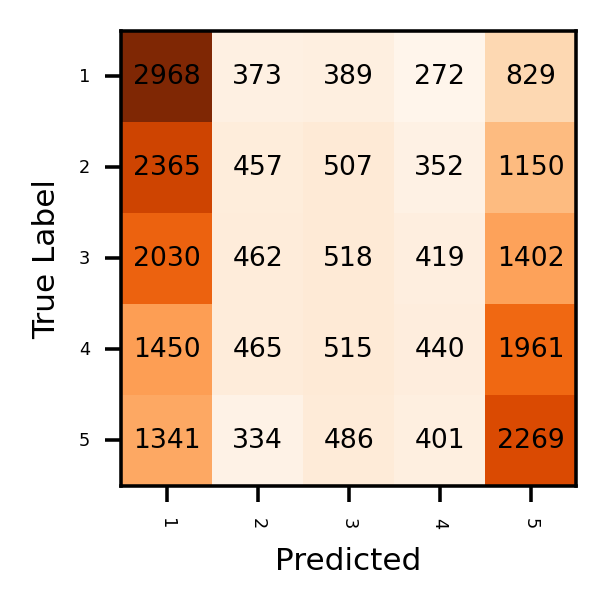

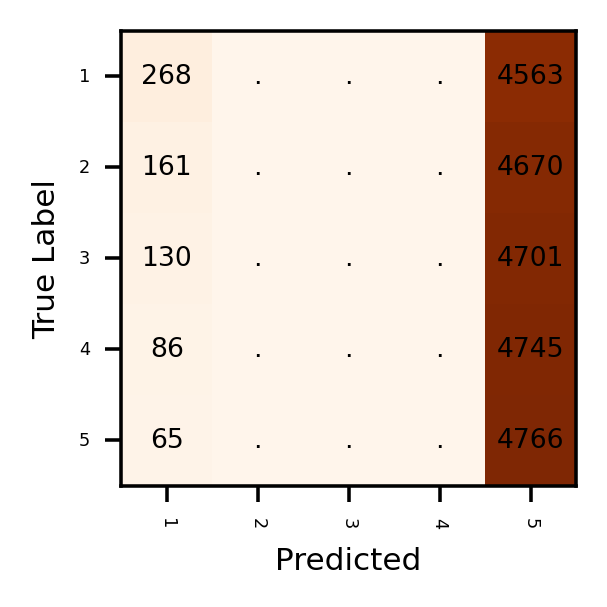

In [0]:
plot_confusion_matrix(list(val['Score']), list(val['Predict']), [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'threshholding baseline', normalize=False)
plot_confusion_matrix(list(val['Score']), model_lr.predict(list(val['pos_neg'])), [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'logisticregression baseline', normalize=False)

**Submitting your solutions:** As in the previous homeworks, implement the below header that takes in a Pandas dataframe and returns the predictions of review scores for each of the Amazon reviews.

In [0]:
# Inputs: The input to this function is the path to the input CSV file
# Outputs: Return a **numpy** array with your score predictions. 
# **Note** that these score predictions should be between *1-5*.

def generate_baseline_predictions(input_df):
  # TODO: Write your code here
  res = []
  data = pd.read_csv(input_df)
  for s in data['Text']:
    ro,_,_ = ratio(s)
    res.append(classify(ro))
  res = np.array(res)
  return res

def generate_logistic_regression_predictions(input_df):
  # TODO: Write your code here
  res = []
  data = pd.read_csv(input_df)
  for s in data['Text']:
    _,pos,neg = ratio(s)
    res.append(model_lr.predict([(pos,neg)])[0])
  res = np.array(res)
  return res

In [0]:
test_case_1b = generate_test_predictions(generate_baseline_predictions)            # 2 pts
test_case_1c = generate_test_predictions(generate_logistic_regression_predictions)      # 3 pts

# Q2. Featurizing the dataset using torchtext (10 pts)

As you saw, data for computer vision is relatively easy to format, simply resize or pad it to a standard format and you can feed it into your neural network. However, text data typically requires more processing before it can be used seamlessly with PyTorch. Thankfully, Pytorch created torchtext, which (similar to torchvision) provides the preprocessing tools to work with textual data.

In this question, we will create and featurize a torchtext dataset with Fields, a data structure that can automatically featurize text with its corresponding word embeddings. We will be using the same dataset for the review classification and the summary generation task. Now, lets load the data required only for the review classification task.





## Q2a. Create torchtext data fields (0 pts)

First, we create TorchText "Fields". Fields describe how to process the input data so it can later be converted to a tensor. For the classification task, we need only two fields from the data - the review text and the review score. Create two torchtext data fields using data.Field from torchtext.data. The documentation for torchtext is [here](https://torchtext.readthedocs.io/en/latest/).


*   A sequential field named TEXT for the review text.  (*Hint: since this is natural language, this is sequential data.  Also, use the "spacy" tokenizer to tokenize the text. This tokenizer handles converting a string into a series of single words. If you're curious how the spaCy tokenizer works, check out its website [here](https://spacy.io/usage/linguistic-features#tokenization). Also to standardize the tokens, we highly recommend making it lowercase.*)
*   A non-sequential field named SCORE for the scores.  (*Hint: since this is a categorical variable, it is not sequential.  Furthermore, it does not require a vocabulary since there are no words to embed.*)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torchtext.data as data
from collections import Counter
from sklearn.metrics import f1_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

from torch.utils.tensorboard import SummaryWriter

In [0]:
%tensorboard --logdir '/content/runs'

In [0]:
# TODO: INSERT CODE HERE
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, include_lengths=True)
LABEL = data.Field(sequential=False, use_vocab=False)

## Q2b. Create a Tabular Dataset (3 pts)

Now that we've defined the two Fields, which determine how to process our data, let's actually produce a dataset with our data! TorchText provides a class called a ```TabularDataset``` which reads in the input data (in this case in the form of a CSV file) and produces a Dataset from it.

Now, look at the [documentation](https://torchtext.readthedocs.io/en/latest/data.html#tabulardataset) for `data.TabularDataset` and create two tabular datasets, one for your training data and one for your testing data.  You will need the paths to the training and validation datasets, the format, and the mapping from columns to fields.  
The mapping from columns to fields should be provided as a list of tuples where the first tuple element should be the name of the column in the csv and the second element should be the corresponding Field created in the previous step. Columns which you do not use/require will need to be indicated by using *None* for that column in place of the field.
Note that the first column in the csv's should not be a field. Also note that while loading the dataset, we would want to ignore the first row (which represents the header).


**NOTE :** This step creates 2 torchtext objects for each row in the dataset, so it will take some time (between 2-10 minutes).

In [0]:
# TODO: INSERT CODE HERE
datafields = [(' ', None), (' ', None), (' ', None), (' ', None), (' ', None), (' ', None), \
              (' ', None), ('Score', LABEL), (' ', None), ('Summary', TEXT), ('Text', TEXT)]

training_data = data.TabularDataset(root_path + 'train.csv', format='csv', fields=datafields, skip_header=True)
val_data = data.TabularDataset(root_path + 'val.csv', format='csv', fields=datafields, skip_header=True)

**Q2b (3 pt)** Now, use the dataset created above to print 5 examples of reviews and their rating. Each example should be a tokenized list of the review. Include a screenshot of the output to the write-up


In [0]:
# TODO: INSERT CODE HERE
for i,s in enumerate(training_data):
  if i==5: break
  print("*******************************")
  print("Summary: ", s.Summary)
  print("Text: ", s.Text)
  print("Label: ", s.Score)

*******************************
Summary:  ['tastes', 'great', '!']
Text:  ['these', 'remind', 'of', 'a', 'product', 'called', 'munchos', 'that', 'i', 'liked', 'a', 'long', 'time', 'ago', 'in', 'regards', 'to', 'flavor', '.', 'great', 'crunch', 'and', 'salt', 'level', '.', 'i', 'wish', 'they', 'packages', 'a', 'bit', 'bigger', 'than', 'the', '0.8', 'and', 'smaller', 'than', '3', 'oz', '.', ' ', 'the', '0.8', 'is', 'nt', 'quite', 'enough', 'and', 'the', '3', 'is', 'too', 'much', '.', 'about', '1.5', 'oz', 'would', 'be', 'right', 'for', 'my', 'appetite', '.']
Label:  4
*******************************
Summary:  ['these', 'were', 'good']
Text:  ['i', 'would', "n't", 'describe', 'these', 'as', 'the', 'best', 'dried', 'cherries', 'i', 'have', 'ever', 'eaten', 'but', 'they', 'were', 'pretty', 'good.<br', '/><br', '/>traverse', 'uses', 'oil', 'with', 'the', 'cherries', 'to', 'prevent', 'caking', ',', 'a', 'little', 'to', 'much', 'in', 'my', 'opinion', '.', ' ', 'these', 'cherries', 'unlike', 't

## Q2c. Build Vocab (3 pts)

Now that we have our text parsed, how do we actually represent our data as tensors? To do this, we use word embeddings, which we highly recommend reading about if you do not understand what they are. Using these word embeddings, we then build our vocabulary with GloVE, a word embedding similar to Word2Vec.  Create a vocabulary from the Field created in Q2a using the train dataset (*Hint: look at the documentation for Field.build_vocab*).  Use the glove.6B.300d word embedding, and save the vocbulary.  The first time you run this, it will take roughly 5-10 minutes to download.  The pretrained model will then be stored in the ./.vector_cache folder, and rerunning this command will take negligible time.

Note that you can pass more than one datafield to the `build_vocab` function. Build a single vocab for both, the training data and validation data.

**Q2c (3 pts)** Print four properties of the `vocab` - ('freqs', 'itos', 'stoi', 'vectors'). Include a screenshot of the printouts in your writeup. Report the size of the vocabulary.

In [0]:
# TODO: INSERT CODE HERE
TEXT.build_vocab(training_data, val_data, min_freq=3, vectors=torchtext.vocab.GloVe(name='6B', dim=300))

In [0]:
print(f'freqs: {TEXT.vocab.freqs}')

In [0]:
print(f'itos: {TEXT.vocab.itos}')

In [0]:
print(f'stoi: {TEXT.vocab.stoi}')

In [0]:
print(f'vectors: {TEXT.vocab.vectors}')

In [0]:
print(f'vocabulary size: {len(TEXT.vocab)}')

## Q2d. Create an iterator for the dataset (0 pts)

Now, create a `BucketIterator` for the training data and the validation data. The `BucketIterator` is equivalent to the `DataLoader`. It splits the data into batches which can be used with recurrent models. This will create batches and add `<pad>` token so that each batch will have the same length. `BucketIterator` creates batches such that the amount of padding is minimum. You will need to sort each batch by the length of the text in decreasing order (this is required for passing the batch through recurrent layers). Look at the documentation of `torchtext.data.BucketIterator` and check the `sort_key` parameter.

In [0]:
# TODO: INSERT CODE HERE
batch_size = 64

# define the train iterator
train_iterator = data.BucketIterator(
    training_data, 
    batch_size = batch_size, 
    sort_key = lambda x: len(x.Text),
    sort_within_batch = True, 
    repeat = False, 
    shuffle = True,
    device = device ) 

# define the test iterator
val_iterator = data.BucketIterator(
    val_data,
    batch_size = batch_size,
    sort_key = lambda x: len(x.Text),
    sort_within_batch = True,
    repeat = False,
    shuffle = True,
    device = device )

## Q2e. Get frequency distribution per class (4 pts)

**Q2e (4 pts):** Now, print the frequency distribution for each class for the training data and the validation data. Report the frequencies in your write-up.

In [0]:
# TODO: INSERT CODE HERE
train_scores, val_scores = [], []
for i, d in enumerate(train_iterator):
  train_scores += d.Score.tolist()
for i, d in enumerate(val_iterator):
  val_scores += d.Score.tolist()

train_freq, val_freq = dict(Counter(train_scores)), dict(Counter(val_scores))
train_sum, val_sum = sum(train_freq.values()), sum(val_freq.values())
for k,v in train_freq.items():
  train_freq[k] = v/train_sum
for k,v in val_freq.items():
  val_freq[k] = v/val_sum

print(f'training frequency: {train_freq}')
print(f'validation frequency: {val_freq}')

training frequency: {5: 0.6389846348368654, 3: 0.07530579148456612, 4: 0.1415464115884665, 2: 0.052356999532723124, 1: 0.09180616255737885}
validation frequency: {5: 0.2, 4: 0.2, 2: 0.2, 3: 0.2, 1: 0.2}


# Q3. Recurrent Amazon Reviews Classifier (25 pts)

We will now build the model for predicting the rating given the review. 

As we are working with text, we will first build a model which uses recurrent layers. Define a model for the classifier which uses *RNN*, *GRU*, *LSTM* and *BiLSTM* layers to predict the rating. You can make four different models or can make a single model with a `mode` parameter which defines which of the four recurrent layers to use. We highly recommend the latter approach, it will make the process much quicker.

**Define the basic recurrent model**

The model should have a `nn.Embedding` layer whose weights should be initialized to the pretrained embeddings downloaded above. The hidden state output from the last timestep should be passed to one (or more) fully connected layers to produce the output. For the *BiLSTM* model, you can choose to either add or concatenate the hidden state for the two directions (feel free to experiment with both and pick the one which works the best).

For this assignment, we will use the *F1 score* to monitor performance of the model. Check `sklearn.metrics.f1_score` to calculate the F1 score.

**NOTE:** Also we recommend you use `nn.utils.rnn.pad_packed_sequence` before passing the input to the recurrent layers. This will make sure the padding is ignored for every sample in a batch and the output will be from the actual last token for every sequence.

In [0]:
class ReviewClassifier(nn.Module):
  """ 
  Review Classifier

  Here we give you the method header for the Review Classifier to make the process easier.
  You don't have to use this exact format, feel free to change the parameters as much as you
  would like, these are simply the parameters that our solution had.

  Parameters: 
  mode (string): Type of recurrent layer being used. Types are ['rnn', 'lstm', 'gru', 'bilstm']
  output_size (int): Size of the last layer for classification (hint: how many classes do you have?)
  hidden_size (int): Length of your hidden state vector
  vocab_size (int): Length of your vocab (can get this by doing len(TEXT.vocab))
  embedding_length (int): Dimension of your word embedding vector (hint: look at part 2c)
  word_embeddings (Tensor): All of the word embeddings generated. Can get this from TEXT.vocab.vectors
  """
  def __init__(self, mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
    super(ReviewClassifier, self).__init__()

    if mode not in ['rnn', 'lstm', 'gru', 'bilstm']:
      raise ValueError("Choose a mode from - rnn / lstm / gru / bilstm")

    self.mode = mode
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    # Embedding Layer
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_length)
    self.embedding.weights = nn.Parameter(word_embeddings, requires_grad=False)

    if self.mode == 'lstm':
      # LSTM Layer
      self.recurrent1 = nn.LSTM(self.embedding_length, self.hidden_size)
      self.recurrent2 = nn.LSTM(self.embedding_length, self.hidden_size)
    elif self.mode == 'bilstm':
      # BILSTM Layer
      self.recurrent1 = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional=True)
      self.recurrent2 = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional=True)
    elif self.mode == 'gru':
      # GRU Layer
      self.recurrent1 = nn.GRU(self.embedding_length, self.hidden_size)
      self.recurrent2 = nn.GRU(self.embedding_length, self.hidden_size)
    else:
      # RNN Layer
      self.recurrent1 = nn.RNN(self.embedding_length, self.hidden_size)
      self.recurrent2 = nn.RNN(self.embedding_length, self.hidden_size)

    # Fully Connected Layer
    self.fc1 = nn.Linear(2 * self.hidden_size, self.hidden_size)
    self.fc2 = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, text, summary, text_lengths, summary_lengths):
    # Embed the sentences
    embedded_text = self.embedding(text)
    embedded_summary = self.embedding(summary)

    # Pack the embedded text
    packed_text = nn.utils.rnn.pack_padded_sequence(embedded_text, text_lengths)
    packed_summary = nn.utils.rnn.pack_padded_sequence(embedded_summary, summary_lengths, enforce_sorted=False)

    # Train the model
    if self.mode == 'rnn' or self.mode == 'gru':
      _, hidden_text = self.recurrent1(packed_text)
      _, hidden_summary = self.recurrent2(packed_summary)
    elif self.mode == 'lstm':
      _, (hidden_text, _) = self.recurrent1(packed_text)
      _, (hidden_summary, _) = self.recurrent2(packed_summary)
    else:
      _, (hidden_text, _) = self.recurrent1(packed_text)      
      _, (hidden_summary, _) = self.recurrent2(packed_summary)
      hidden_text = (hidden_text[0] + hidden_text[1]).unsqueeze(0)
      hidden_summary = (hidden_summary[0] + hidden_summary[1]).unsqueeze(0)
      # adding hidden_state, get training F1-score: 0.8573, validation F1-score: 0.7234
      # concatenating hidden_state, get training F1-score: 0.6989, validation F1-score: 0.3815
      # hidden_text = torch.cat((hidden_text[0], hidden_text[1]), dim=1).unsqueeze(0)
      # hidden_summary = torch.cat((hidden_summary[0], hidden_summary[1]), dim=1).unsqueeze(0)

    # Fully connected layer
    fc_input = torch.cat((hidden_text, hidden_summary), dim=2).squeeze(0)
    temp = nn.ReLU()(self.fc1(fc_input))
    prediction = self.fc2(temp)
    return prediction

In [0]:
def train_classifier(model, dataset_iterator, loss_function, optimizer, \
                     epochs = 10, log = "runs", verbose = True, print_every = 100, recurrent = False):
  #tensorboard writer
  writer = SummaryWriter(log_dir=log) 
  model.train()
  step = 0

  for epoch in range(epochs):
    total = 0
    total_loss = 0
    
    for batch in dataset_iterator:
      text, text_length = batch.Text
      summary, summary_length = batch.Summary
      labels = batch.Score - 1
 
      batch_size = len(labels)
      if torch.sum(text_length)<batch_size or torch.sum(summary_length)<batch_size or any(text_length<=0) or any(summary_length<=0):
        continue
      
      optimizer.zero_grad()
      if recurrent:
        output = model(text, summary, text_length, summary_length).squeeze(1)
      else:
        output = model(text, summary).squeeze(1) 

      labels = labels.type_as(output).long()
      loss = loss_function(output, labels)
      loss.backward()
      optimizer.step()

      _,pred = torch.max(output.data, 1)
      f1 = f1_score(labels.data.cpu(), pred.data.cpu(), average='macro')
      total += labels.size(0)
      total_loss += loss.item()
  
      if ((step % print_every) == 0):
        writer.add_scalar("Training Loss", total_loss/total, step)
        writer.add_scalar("Training F1-Score", f1, step)
        if verbose:
          print("--- Step: %s F1-Score: %.4f Loss: %.4f" %(step, f1, total_loss/total))
      step = step+1

    print("Epoch: %s F1-Score: %.4f Loss: %.4f"%(epoch+1, f1, total_loss/total))

def evaluate_classifier(model, dataset_iterator, loss_function, recurrent = False):
  model.eval()
  total = 0
  total_loss = 0
  true_labels, predict_labels = [], []
  for batch in dataset_iterator:
    text, text_length = batch.Text
    summary, summary_length = batch.Summary
    labels = batch.Score - 1

    if any(text_length<=0) or any(summary_length<=0):
      continue
    
    if recurrent:
      output = model(text, summary, text_length, summary_length).squeeze(1)
    else:
      output = model(text, summary).squeeze(1)

    labels = labels.type_as(output).long()
    loss = loss_function(output, labels)
    _,pred = torch.max(output.data, 1) 
    
    true_labels += (labels+1).tolist()
    predict_labels += (pred+1).tolist()

    f1 = f1_score(labels.data.cpu(), pred.data.cpu(), average='macro')
    total += labels.size(0)
    total_loss += loss.item()

  print("Test statistics: F1-Score: %.4f Loss: %.4f"%(f1, total_loss/total))
  return true_labels, predict_labels

**Train the Recurrent Models**

**Q3b (2 pts):** Train the model defined above with *LSTM* as the recurrent layer. Use the standard `nn.CrossEntropyLoss` as the loss function.  Report the final training F1 score and the final training loss of the model (trained only on the training set). Use the trained model to evaluate on the validation data. Report the validation F1 score. Use the `plot_confusion_matrix` function to display the confusion matrix for the validation set. Report this confusion matrix to your write-up. Report your final hyper-parameter choices in your writeup as well as your hyper-parameter tuning process.

In [0]:
output_size = 5
hidden_size = 256
vocab_size = len(TEXT.vocab)
embedding_length = 300
word_embeddings = TEXT.vocab.vectors
epochs = 5

In [0]:
# Establish LSTM
model_lstm = ReviewClassifier('lstm', output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model_lstm = model_lstm.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

logger_lstm = 'runs/lstm'
train_classifier(model_lstm, train_iterator, criterion, optimizer, log = logger_lstm, epochs = epochs, print_every = 100, recurrent = True)
true_labels_lstm, predict_labels_lstm = evaluate_classifier(model_lstm, val_iterator, criterion, recurrent = True)

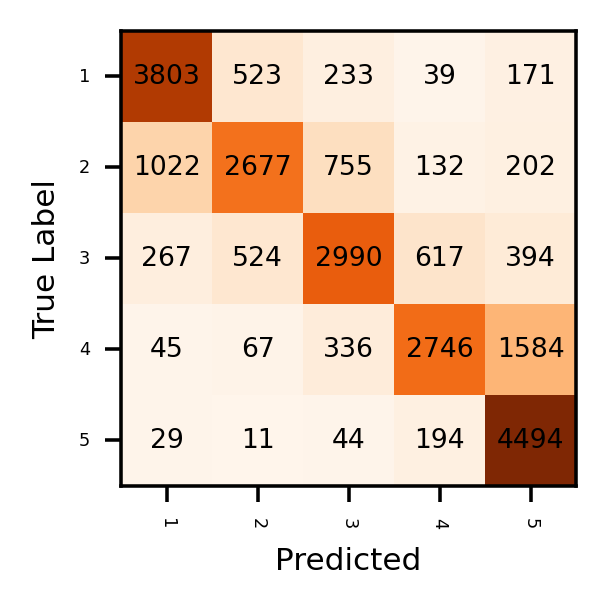

In [0]:
plot_confusion_matrix(true_labels_lstm, predict_labels_lstm, [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'LSTM', normalize=False)

**Q3c (2 pts):** What issue do you find after looking at the confusion matrix? What according to you is the reason for this difference? What would you do to fix it? *Hint:* Note what you observed in Q2e. The fix has something to do with the loss function.

In [0]:
# TODO: INSERT CODE HERE
w1, w2, w3, w4, w5 = train_freq[1], train_freq[2], train_freq[3], train_freq[4], train_freq[5]
weights = torch.tensor([w1, w2, w3, w4, w5]).to(device)

**Q3d (2 pts):** Now redo 3b except with the fix for the problem that you noted in Q3c. Report all the same things in your writeup, and explain how adding this fix impacted results. Use the confusion matrix and the F1 Score in your analysis.

In [0]:
# TODO: INSERT CODE HERE
model_lstm_revised = ReviewClassifier('lstm', output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model_lstm_revised = model_lstm_revised.to(device)
criterion_revised = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model_lstm_revised.parameters(), lr=0.001)

logger_lstm_revised = 'runs/lstm_revised'
train_classifier(model_lstm_revised, train_iterator, criterion_revised, optimizer, log = logger_lstm_revised, epochs = epochs, print_every = 100, recurrent = True)
true_labels_lstm_revised, predict_labels_lstm_revised = evaluate_classifier(model_lstm_revised, val_iterator, criterion, recurrent = True)

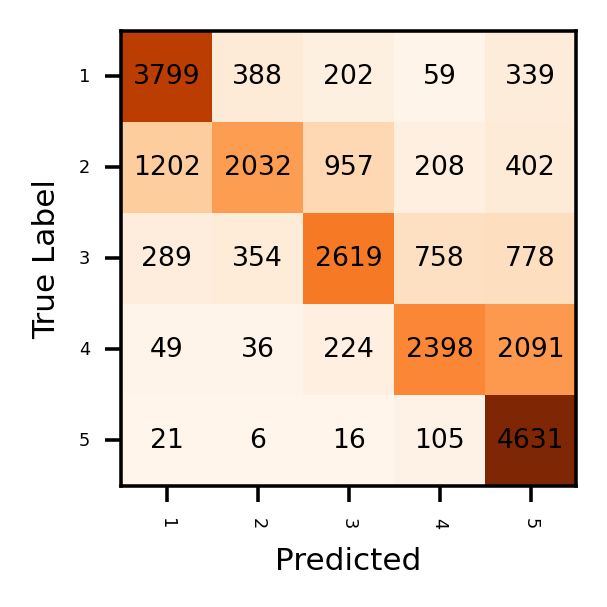

In [0]:
plot_confusion_matrix(true_labels_lstm_revised, predict_labels_lstm_revised, [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'LSTM', normalize=False)

**Q3e (10 pts):** Train the model with the other three recurrent layers. Plot the training loss and training F1 score for all four (including the one trained in Q3b-d) models on the same graph. (You will provide two plots, one with the training loss for all 4 models and the other with the training F1 score for all 4 models). Also report the confusion matrix for all the four trained models for the validation set. What do you observe? Compare the four models and provide a rough intuition as to why the models performed the way they did. 

In [0]:
# Establish RNN
model_rnn = ReviewClassifier('rnn', output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model_rnn = model_rnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

logger_rnn = 'runs/rnn'
train_classifier(model_rnn, train_iterator, criterion, optimizer, log = logger_rnn, epochs = epochs, print_every = 100, recurrent = True)
true_labels_rnn, predict_labels_rnn = evaluate_classifier(model_rnn, val_iterator, criterion, recurrent = True)

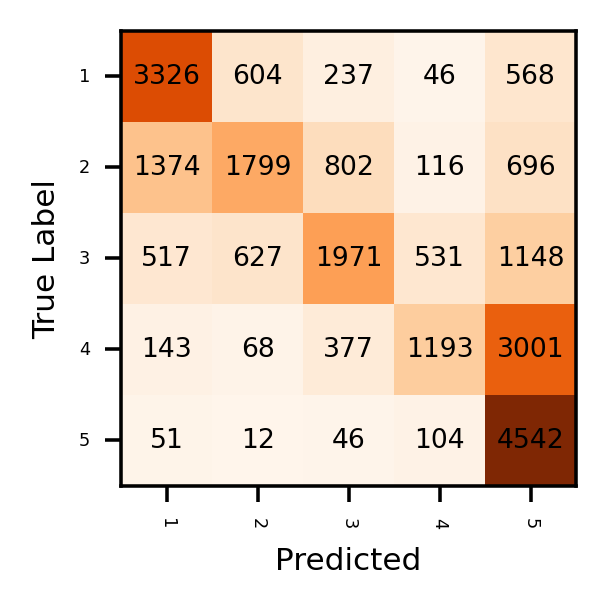

In [0]:
plot_confusion_matrix(true_labels_rnn, predict_labels_rnn, [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'RNN', normalize=False)

In [0]:
# Establish GRU(Gated Recurrent Unit) - revised LSTM
model_gru = ReviewClassifier('gru', output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model_gru = model_gru.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)

logger_gru = 'runs/gru'
train_classifier(model_gru, train_iterator, criterion, optimizer, log = logger_gru, epochs = epochs, print_every = 100, recurrent = True)
true_labels_gru, predict_labels_gru = evaluate_classifier(model_gru, val_iterator, criterion, recurrent = True)

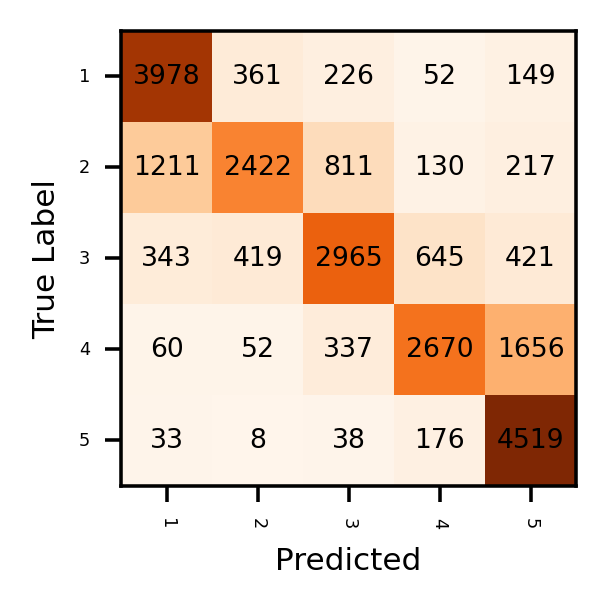

In [0]:
plot_confusion_matrix(true_labels_gru, predict_labels_gru, [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'GRU', normalize=False)

In [0]:
# Establish BILSTM via adding the hidden state
model_bilstm = ReviewClassifier('bilstm', output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model_bilstm = model_bilstm.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bilstm.parameters(), lr=0.001)

logger_bilstm = 'runs/bilstm'
train_classifier(model_bilstm, train_iterator, criterion, optimizer, log = logger_bilstm, epochs = epochs, print_every = 100, recurrent = True)
true_labels_bilstm, predict_labels_bilstm = evaluate_classifier(model_bilstm, val_iterator, criterion, recurrent = True)

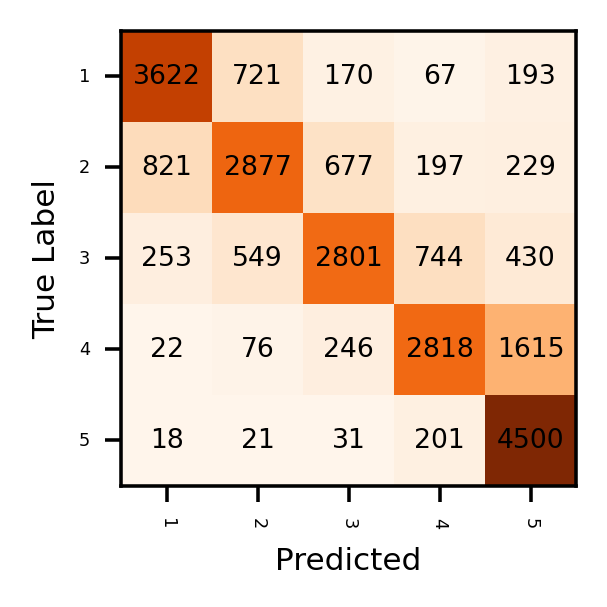

In [0]:
plot_confusion_matrix(true_labels_bilstm, predict_labels_bilstm, [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'BILSTM', normalize=False)

**Submitting your solutions:** As in the previous homeworks, implement the below header that takes in a Pandas dataframe and returns the predictions of review scores for each of the Amazon reviews.

**NOTE:** Remember to set the `sort` argument of the `BucketIterator` to `False` when initializing the iterator for the test set. Also set `shuffle` to `False` and use a batch size of 1. This will make sure the generated predictions are in the same order as the test set.

In [0]:
# Inputs: The input to this function is the path to the input CSV file
# Outputs: Return a **numpy** array with your score predictions. 
# **Note** that these score predictions should be between *1-5*.

def generate_rnn_predictions(input_df):
  # TODO: Write your code here
  datafields = [(' ', None), ('Summary', TEXT), ('Text', TEXT)]
  test_data = data.TabularDataset(input_df, format='csv', fields=datafields, skip_header=True)
  test_iterator = data.BucketIterator(test_data, batch_size=1, sort=False, repeat=False, shuffle=False, device=device)
  res = []
  for batch in test_iterator:
    text, text_length = batch.Text
    summary, summary_length = batch.Summary
    if text_length==0 or summary_length==0: 
      res.append(5)
      continue
    output = model_rnn(text, summary, text_length, summary_length).squeeze(1)
    _,pred = torch.max(output.data, 1)
    res += (pred+1).tolist()
  return np.array(res)

def generate_gru_predictions(input_df):
  # TODO: Write your code here
  datafields = [(' ', None), ('Summary', TEXT), ('Text', TEXT)]
  test_data = data.TabularDataset(input_df, format='csv', fields=datafields, skip_header=True)
  test_iterator = data.BucketIterator(test_data, batch_size=1, sort=False, repeat=False, shuffle=False, device=device)
  res = []
  for batch in test_iterator:
    text, text_length = batch.Text
    summary, summary_length = batch.Summary
    if text_length==0 or summary_length==0:  
      res.append(5)
      continue
    output = model_gru(text, summary, text_length, summary_length).squeeze(1)
    _,pred = torch.max(output.data, 1)
    res += (pred+1).tolist()
  return np.array(res)

def generate_lstm_predictions(input_df):
  # TODO: Write your code here
  datafields = [(' ', None), ('Summary', TEXT), ('Text', TEXT)]
  test_data = data.TabularDataset(input_df, format='csv', fields=datafields, skip_header=True)
  test_iterator = data.BucketIterator(test_data, batch_size=1, sort=False, repeat=False, shuffle=False, device=device)
  res = []
  for batch in test_iterator:
    text, text_length = batch.Text
    summary, summary_length = batch.Summary
    if text_length==0 or summary_length==0: 
      res.append(5)
      continue
    output = model_lstm(text, summary, text_length, summary_length).squeeze(1)
    _,pred = torch.max(output.data, 1)
    res += (pred+1).tolist()
  return np.array(res)

def generate_bilstm_predictions(input_df):
  # TODO: Write your code here
  datafields = [(' ', None), ('Summary', TEXT), ('Text', TEXT)]
  test_data = data.TabularDataset(input_df, format='csv', fields=datafields, skip_header=True)
  test_iterator = data.BucketIterator(test_data, batch_size=1, sort=False, repeat=False, shuffle=False, device=device)
  res = []
  for batch in test_iterator:
    text, text_length = batch.Text
    summary, summary_length = batch.Summary
    if text_length==0 or summary_length==0:  
      res.append(5)
      continue
    output = model_bilstm(text, summary, text_length, summary_length).squeeze(1)
    _,pred = torch.max(output.data, 1)
    res += (pred+1).tolist()
  return np.array(res)

In [0]:
test_case_3e_rnn    = generate_test_predictions(generate_rnn_predictions)        # 1 pts  
test_case_3e_gru    = generate_test_predictions(generate_gru_predictions)        # 2 pts
test_case_3e_lstm    = generate_test_predictions(generate_lstm_predictions)       # 3 pts
test_case_3e_bilstm   = generate_test_predictions(generate_bilstm_predictions)      # 3 pts

# Q4. Classifier with self-attention (30 pts)

Now, we will implement the Review Classifier with self-attention. Self-attention is a technique where we score the input sequence hidden states with respect to the final hidden representation we use for classification. 

Attention is a very useful technique used in all of deep learning to figure out what parts of the input are more important for producing the output. This helps us use a more relevant feature representation of the input with respect to the end goal. In NLP applications, we typically want to know which words (or tokens) in the input sequence are important for our task. In this assignment, we are interested to figure out what words in the review text are the most important to predict the rating. We call it self-attention because the words from the same input sentence are attended on for the classification.

You can read about attention in more detail from [here](https://medium.com/datadriveninvestor/attention-in-rnns-321fbcd64f05).

Attention was originally introduced for encoder-decoder architectures used for machine translation in [this paper](https://arxiv.org/pdf/1409.0473.pdf).



## Q4a. Define the attention module

Define an `Attention` module (just like you define any model). For this assignment, we will be implementing *additive attention*. So, the inputs to the attention will be passed through fully connected layers and finally through a softmax to output the `attention_scores`. The following figure summarizes the procedure to compute the `attention_scores`. Implement the `forward()` of the `Attention` module as per the figure.

![attention](https://i.imgur.com/uFdThV6.png)

To implement self-attention we will first define an `Attention` module. This module will take as input the final representation with respect to which we want to attend on the input sequence (for this assignment, the last hidden state) and the output of the recurrent layer from each timestep and outputs `attention_scores` which is a probability distribution over each token in the input sequence representing the importance of each token for the final prediction.

In [0]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.fc1 = nn.Linear(hidden_size, 1)
    
  def forward(self, hidden, encoder_outputs):
    """ 
    Parameters: 
    hidden (vector): Final hidden state from the input sequence
    encoder_outputs (tensor): Hidden state produced from each of the input sequence tokens
    """
    alpha = self.fc1(encoder_outputs)
    alpha = F.softmax(alpha, dim=0)
    context = torch.sum(alpha * encoder_outputs, dim=0).unsqueeze(0)
    att = torch.cat((context, hidden), dim=2)
    return att

attention = Attention(hidden_size).to(device)

## Q4b. Define the classifier model with attention

Now, define a model which uses the `Attention` module defines above. This model will be the same as the one defined in section Q3 except that you will compute a `context` vector (calculated as a weighted average of the outputs for each timestep with weights from the `Attention` module) and then concatenate this vector with the last hidden state vector . The context vector concatenated with the last hidden state should be passed through one (or more) fully connected layers to generate the final predictions.

**NOTE:** Pay careful attention to the dimensions of the output. The recurrent layers expect input with the batch size at the second dimension and sequence length as the first dimension. The output also follows the same rule.

**NOTE:** Also we recommend you use `nn.utils.rnn.pad_packed_sequence` before passing the input to the recurrent layers. This will make sure the padding is ignored for every sample in a batch and the output will be from the last batch 

In [0]:
class ReviewClassifierWithAttention(nn.Module):  
  def __init__(self, mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
    super(ReviewClassifierWithAttention, self).__init__()

    if mode not in ['rnn', 'lstm', 'gru', 'bilstm']:
      raise ValueError("Choose a mode from - rnn / lstm / gru / bilstm")

    self.mode = mode
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    # Embedding Layer
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_length)
    self.embedding.weights = nn.Parameter(word_embeddings, requires_grad=False)

    if self.mode == 'lstm':
      # LSTM Layer
      self.recurrent1 = nn.LSTM(self.embedding_length, self.hidden_size)
      self.recurrent2 = nn.LSTM(self.embedding_length, self.hidden_size)
    elif self.mode == 'bilstm':
      # BILSTM Layer
      self.recurrent1 = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional=True)
      self.recurrent2 = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional=True)
    elif self.mode == 'gru':
      # GRU Layer
      self.recurrent1 = nn.GRU(self.embedding_length, self.hidden_size)
      self.recurrent2 = nn.GRU(self.embedding_length, self.hidden_size)
    else:
      # RNN Layer
      self.recurrent1 = nn.RNN(self.embedding_length, self.hidden_size)
      self.recurrent2 = nn.RNN(self.embedding_length, self.hidden_size)

    # Fully Connected Layer
    self.fc1 = nn.Linear(4 * self.hidden_size, self.hidden_size)
    self.fc2 = nn.Linear(self.hidden_size, self.output_size)


  def forward(self, text, summary, text_lengths, summary_lengths):
    # Embed the sentences
    embedded_text = self.embedding(text)
    embedded_summary = self.embedding(summary)
   
    # Pack the embedded text
    packed_text = nn.utils.rnn.pack_padded_sequence(embedded_text, text_lengths)
    packed_summary = nn.utils.rnn.pack_padded_sequence(embedded_summary, summary_lengths, enforce_sorted=False)

    # Train the model
    if self.mode == 'rnn' or self.mode == 'gru':
      output_text, hidden_text = self.recurrent1(packed_text)
      output_summary, hidden_summary = self.recurrent2(packed_summary)
    elif self.mode == 'lstm':
      output_text, (hidden_text, _) = self.recurrent1(packed_text)
      output_summary, (hidden_summary, _) = self.recurrent2(packed_summary)
    else:
      output_text, (hidden_text, _) = self.recurrent1(packed_text)      
      output_summary, (hidden_summary, _) = self.recurrent2(packed_summary)
      hidden_text = (hidden_text[0] + hidden_text[1]).unsqueeze(0)
      hidden_summary = (hidden_summary[0] + hidden_summary[1]).unsqueeze(0)

    # Unpack the text
    unpacked_text,_ = nn.utils.rnn.pad_packed_sequence(output_text)    
    unpacked_summary,_ = nn.utils.rnn.pad_packed_sequence(output_summary)
    if self.mode == 'bilstm':
      unpacked_text = unpacked_text[:,:,:self.hidden_size] + unpacked_text[:,:,self.hidden_size:]
      unpacked_summary = unpacked_summary[:,:,:self.hidden_size] + unpacked_summary[:,:,self.hidden_size:]

    # Attention layer    
    attention_text = attention(hidden_text, unpacked_text)
    attention_summary = attention(hidden_summary, unpacked_summary)

    # Fully connected layer
    fc_input = torch.cat((attention_text, attention_summary), dim=2).squeeze(0)
    temp = nn.ReLU()(self.fc1(fc_input))
    prediction = self.fc2(temp)
    return prediction

## Q4c. Training the attention model

Train the model defined above using the recurrent layer which performed the best in the previous section. (You can choose to tune the hyperparameters - recurrent layers, hidden size, etc. also to pick the best model with self attention). 

**Q4c (5 pts):** Report the final accuracy, F1 score and loss for the training and validation sets. Include the training and validation plots in your write-up. Also plot the confusion matrix for the validation data and include it in your write-up.

**Q4d (5 pts):** How does the model with and without self attention compare? What do you think intuitively explains the difference in performance?

In [0]:
# Establish BILSTM with attention
model_bilstm_att = ReviewClassifierWithAttention('bilstm', output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model_bilstm_att = model_bilstm_att.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bilstm_att.parameters(), lr=0.001)

logger_bilstm_att = 'runs/bilstm_att'
train_classifier(model_bilstm_att, train_iterator, criterion, optimizer, log = logger_bilstm_att, epochs = epochs, print_every = 100, recurrent = True)
true_labels_bilstm_att, predict_labels_bilstm_att = evaluate_classifier(model_bilstm_att, val_iterator, criterion, recurrent = True)

Validation Acc: 0.7103644503954141


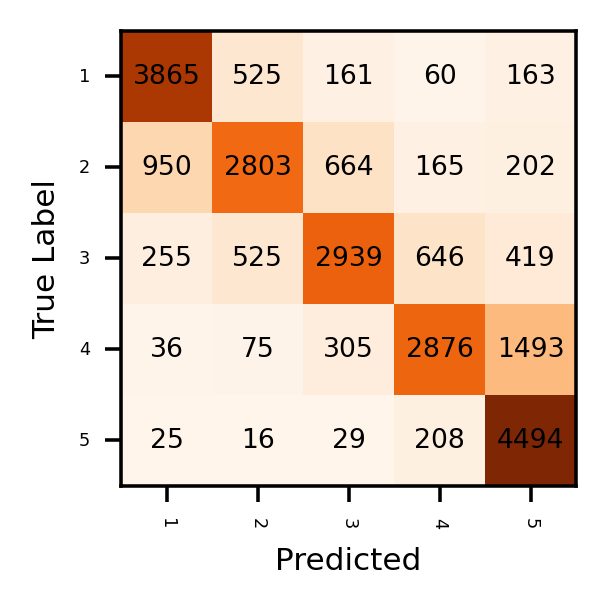

In [0]:
final_accuracy = np.argwhere(np.array(true_labels_bilstm_att)==np.array(predict_labels_bilstm_att)).size/len(true_labels_bilstm_att)
print(f'Validation Acc: {final_accuracy}')
plot_confusion_matrix(true_labels_bilstm_att, predict_labels_bilstm_att, [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'BILSTM', normalize=False)

**Submitting your solutions:** As in the previous homeworks, implement the below header that takes in a Pandas dataframe and returns the predictions of review scores for each of the Amazon reviews.

In [0]:
# Inputs: The input to this function is the path to the input CSV file
# Outputs: Return a **numpy** array with your score predictions. 
# **Note** that these score predictions should be between *1-5*.

def generate_attention_predictions(input_df):
  # TODO: Write your code here
  datafields = [(' ', None), ('Summary', TEXT), ('Text', TEXT)]
  test_data = data.TabularDataset(input_df, format='csv', fields=datafields, skip_header=True)
  test_iterator = data.BucketIterator(test_data, batch_size=1, sort=False, repeat=False, shuffle=False, device=device)
  res = []
  for batch in test_iterator:
    text, text_length = batch.Text
    summary, summary_length = batch.Summary
    if text_length==0 or summary_length==0:  
      res.append(5)
      continue
    output = model_bilstm_att(text, summary, text_length, summary_length).squeeze(1)
    _,pred = torch.max(output.data, 1)
    res += (pred+1).tolist()
  return np.array(res)

In [0]:
test_case_4e = generate_test_predictions(generate_attention_predictions)         # 20 pts  

# Q5. Transfer Learning using Hugging Face (20 pts)

As you saw in the computer vision homework, transfer learning is a powerful tool to boost the accuracy of a model, especially with limited data. Most transfer learning models for text applications are extremely large and difficult to work with, so to make this easier most use a github repository called [Hugging Face](https://github.com/huggingface) (which we highly recommend checking out!). Getting the data to be in the right format for training can be difficult even with Hugging Face, so for this assignment we'll be using a library built on top of Hugging Face called [Simple Transformers](https://github.com/ThilinaRajapakse/simpletransformers), which makes transfer learning extremely easy.

## Setting up Simple Transformers

First we download the pip package for SimpleTransformers

In [0]:
!pip install simpletransformers

Now, to initialize a classification model, you can do so similarly to how we do it below. Feel free to change the args passed in, however, make sure to keep "fp16" set to false (trust us on this).

In [0]:
from simpletransformers.classification import ClassificationModel
model1 = ClassificationModel('roberta', 'roberta-base', num_labels=6, args=({'fp16': False, 'reprocess_input_data': True}))
model2 = ClassificationModel('camembert', 'camembert-base', num_labels=6, args=({'fp16': False, 'reprocess_input_data': True}))

The input format for SimpleTransformers is to have the text data in a columm called "text" and to have the labels as a column called "labels" so let's say your pandas dataframe was called `train_df`, then you would relabel it as follows:

In [0]:
train_df_cleaned = train[['Text', 'Score']].rename(columns={"Text":"text", "Score":"labels"})
test_df_cleaned = val[['Text', 'Score']].rename(columns={"Text":"text", "Score":"labels"})

Great! Now that you've downloaded the model, let's train with it. To train with it, run the following code snippet below. 

**Note:** This will take a pretty long time so grab a coffee, turn on a Netflix show and watch a few episodes, play a few games of Overwatch, whatever you do to kill time. You can actually run up to two Colab runtimes at once, so you can always duplicate this notebook and keep on working on the homework -- up to you.

You'll note that this will progress in two stages: In the first stage the model converts your input data into features (similar to when you created your TabularDataset earlier). In the second stage, it will actually train with those input features and labels, and display the progress to you. For reference, it took around ~3 hours to run through a single epoch of the dataset (yikes).

**Hint:** We recommend that you make sure this works on a subset of your training data / testing data (like 1% of it) before you run it on the whole dataset so you don't waste lots of time.

In [0]:
# Train the model
model1.train_model(train_df_cleaned, output_dir='outputs/model1')

# Evaluate the model
result1, model_outputs1, wrong_predictions1 = model1.eval_model(test_df_cleaned)

In [0]:
# Train the model
model2.train_model(train_df_cleaned, output_dir='outputs/model2')

# Evaluate the model
result2, model_outputs2, wrong_predictions2 = model2.eval_model(test_df_cleaned)

**Q5a (8 pts):** Report your final testing macro average F1 Score as well as confusion matrix in your writeup. Analyze your results in comparison to the recurrent models you  trained previously (including both the self-attention and non self-attention models). Try out at least 2 different models (roberta included) and compare their efficacies in the writeup.


In [0]:
predict1 = np.argmax(model_outputs1, axis=1).tolist()
F1_score1 = f1_score(test_df_cleaned['labels'].tolist(), predict1, average='macro')

print(f'F1-Score of Model 1: {F1_score1}')
plot_confusion_matrix(test_df_cleaned['labels'].tolist(), predict1, [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'BILSTM', normalize=False)

In [0]:
predict2 = np.argmax(model_outputs2, axis=1).tolist()
F1_score2 = f1_score(test_df_cleaned['labels'].tolist(), predict2, average='macro')
print(f'F1-Score of Model 2: {F1_score2}')
plot_confusion_matrix(test_df_cleaned['labels'].tolist(), predict2, [1,2,3,4,5], ['1','2','3','4','5'], title='Confusion matrix', tensor_name = 'BILSTM', normalize=False)

**Submitting your solutions:** As in the previous homeworks, implement the below header that takes in a Pandas dataframe and returns the predictions of review scores for each of the Amazon reviews.

In [0]:
# Inputs: The input to this function is the path to the input CSV file
# Outputs: Return a **numpy** array with your score predictions. 
# **Note** that these score predictions should be between *1-5*.

def generate_transfer_learning_predictions(input_df):
  # TODO: Write your code here
  test_df = pd.read_csv(input_df)
  test_df['Score'] = 0
  test_df_cleaned = test_df[['Text', 'Score']].rename(columns={"Text":"text", "Score":"labels"})
  result, model_outputs, wrong_predictions = model1.eval_model(test_df_cleaned)
  predict = np.argmax(model_outputs, axis=1)
  return predict

In [0]:
test_case_5b = generate_test_predictions(generate_transfer_learning_predictions) # 12 pts

# **Extra Credit:** Q6. Seq2Seq model (25 pts)

**Note:** The entirety of question 6 is **Extra Credit**. This will be a bit more challenging, especially to get good results, but if you have time we highly recommend trying it out!

In this section, you will implement a Seq2Seq architecture to generate the summary for the Review text. The dataset contains one more attribute which is the summary of the review text (it is actually the title reviewers gave while writing the review and the review text is the description provided).

You will implement the standard *Encoder-Decoder* model where the review text will be given as input to the encoder and the decoder will generate the summary. For simplicity of this assignment, we will implement a basic version of the encoder-decoder architecture and use standard training techniques. More sophisticated versions of the architeture like encoder-decoder attention, teacher-forcing (while training), beam search (for inference), etc. will help the model perform better. But for the purpose of this assignment, we will expect you to implement a basic version of the architecture.



## Q6a. Featuring the dataset using torchtext (for the generative task) (0 pts)

For the text generation task, you will need to redefine the torchtext data fields. Create one torchtext field. Note that, we now need to add start and end tokens to both the text sequences. Look at the `init_token` and `eos_token` parameters when creating the data field.

Then create a tabular dataset for the training and validation set. This time also load the *Summary* field. Note that to ensure we create a single common vocabulary for both - the text and summary, we will use the same data field for both the attributes.

Now build the vocabulary for the the data field you created using both the training and validation datasets created in the previous step. As before you should continue using the glove.6B.300d word embeddings.

Then just as you did in Q1, create a `BucketIterator` for both the training and validation set.

In [0]:
# Create torchtext DataField & TabularDataset
TEXT_S2S = data.Field(sequential=True, tokenize='spacy', lower=True, include_lengths=True, init_token='<start>', eos_token='<end>')
datafields = [(' ', None), (' ', None), (' ', None), (' ', None), (' ', None), (' ', None), \
              (' ', None), (' ', None), (' ', None), ('Summary', TEXT_S2S), ('Text', TEXT_S2S)]

train_s2s = data.TabularDataset('/content/drive/My Drive/CIS522 Homeworks/HW4/train.csv', format='csv', fields=datafields, skip_header=True)
val_s2s = data.TabularDataset('/content/drive/My Drive/CIS522 Homeworks/HW4/val.csv', format='csv', fields=datafields, skip_header=True)

In [0]:
# Build Vocabulary for dataset
TEXT_S2S.build_vocab(train_s2s, val_s2s, min_freq=3, vectors=torchtext.vocab.GloVe('6B', dim=300))

.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                           
100%|█████████▉| 399725/400000 [00:51<00:00, 7908.04it/s]

In [0]:
print(f'freqs: {TEXT_S2S.vocab.freqs}')

In [0]:
print(f'stoi: {TEXT_S2S.vocab.itos}')

In [0]:
print(f'vectors: {TEXT_S2S.vocab.vectors}')

In [0]:
print(f'vocabulary size: {len(TEXT_S2S.vocab)}')

In [0]:
# Establish BucketIterator for training set and validation set
batch_size = 64
train_s2s_iterator = data.BucketIterator(train_s2s, batch_size, sort_key=lambda x: len(x.Text), sort_within_batch=True, shuffle=True, device=device)
val_s2s_iterator = data.BucketIterator(val_s2s, batch_size=1, sort_key=lambda x: len(x.Text), sort_within_batch=True, shuffle=True, device=device)

In [0]:
hidden_size = 256
vocab_size = len(TEXT_S2S.vocab)
embedding_size = 300
word_embeddings = TEXT_S2S.vocab.vectors
epochs = 1

## Q6a. The Encoder Model (3 pts)

You will start by defining the encoder model. This model will be exactly the same as the one implemented in section Q3. The encoder's input will be the review text and will return an encoded representation of the text (which will be the output of the recurrent layer you use). Use any one of the recurrent layers like the one which performed the best in section Q3 or tune it as a hyperparameter to choose which works the best.

**Q6a (3 pts):** Take a screenshot of your encoder architecture and attach it in your writeup. Explain your rationale for the architecture.

In [0]:
# Define a BILSTM Encoder
class Encoder(nn.Module):
  def __init__(self, hidden_size, vocab_size, embedding_size, word_embeddings, dropout_v=0.2):
    super(Encoder,self).__init__()
    self.hidden_size = hidden_size 
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.word_embeddings = word_embeddings
    self.dropout = nn.Dropout(dropout_v)

    # Embedding Layer
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
    self.embedding.weights = nn.Parameter(self.word_embeddings, requires_grad=False)

    # BILSTM Layer
    self.recurrent1 = nn.LSTM(self.embedding_size, self.hidden_size, bidirectional=True)

  def forward(self, text):
    # Embedding Layer
    embedded_text = self.embedding(text)
    embedded_text = self.dropout(embedded_text)

    # BILSTM Layer
    output_text, (hidden_text,_) = self.recurrent1(embedded_text)
    hidden_text = (hidden_text[0] + hidden_text[1]).unsqueeze(0)
    output_text = output_text[:,:,:self.hidden_size] + output_text[:,:,self.hidden_size:]  
    return output_text, hidden_text

encoder = Encoder(hidden_size, vocab_size, embedding_size, word_embeddings).to(device)

100%|█████████▉| 399725/400000 [01:10<00:00, 7908.04it/s]

## Q6b. The Decoder Model (3 pts)

Define the `decoder` model. It will be the same as the `encoder` model with the only difference being there will be an additional fully-connected layer after the output from each token in the sequence. This FC layer will have an output size equal to the vocabulary size.

**Q6b (3 pts):** Take a screenshot of your decoder architecture and attach it in your writeup. Explain your rationale for the architecture.

In [0]:
# Define a BILSTM Decoder
class Decoder(nn.Module):
  def __init__(self, hidden_size, vocab_size, embedding_size, word_embeddings, dropout_v=0.2):
    super(Decoder,self).__init__()
    self.hidden_size = hidden_size 
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.word_embeddings = word_embeddings
    self.dropout = nn.Dropout(dropout_v)

    # Embedding Layer
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
    self.embedding.weights = nn.Parameter(self.word_embeddings, requires_grad=False)

    # BILSTM Layer
    self.recurrent1 = nn.LSTM(self.embedding_size+self.hidden_size, self.hidden_size, bidirectional=True)

    # Fully Connected Layer
    self.fc1 = nn.Linear(self.hidden_size, self.vocab_size)

  def forward(self, encoder_hidden, decoder_input):    
    # decoder_input = [batch_size], embedded_input = [1, batch_size, embedding_size]
    embedded_input = self.embedding(decoder_input.unsqueeze(0))
    embedded_input = self.dropout(embedded_input) 

    # encoder_hidden = [1, batch_size, hidden_size]
    input_rnn = torch.cat((encoder_hidden, embedded_input), dim=2)
    output_rnn, (hidden_rnn,_) = self.recurrent1(input_rnn)
    output_rnn = output_rnn[:,:,:self.hidden_size] + output_rnn[:,:,self.hidden_size:]

    # Fully Connected Layer
    prediction = self.fc1(output_rnn.squeeze(0))
    return prediction

decoder = Decoder(hidden_size, vocab_size, embedding_size, word_embeddings).to(device)

## Q6c. The Encoder-Decoder Model (4 pts)

Now, you will define the encoder-decoder model which represents the overall architecture end-to-end. 

The encoder-decoder architeture will behave as follows,


*   Pass the review text as input through the encoder.
*   Initialize the hidden state of the decoder with the last hidden state output from the encoder.
*   The decoder will take the `<start>` token as the input in the first timestep and produce an output one timestep at a time. This means your decoder should be passed only one token at a time and output a single token. The output from the previous timestep will be fed as input in the current timestep.
*   Return the output from the decoder concatenated at each timestep.

While training, the decoder will generate outputs till the maximum summary length for that batch. This means, you will call the decoder in a for loop which runs till the length of the decoder output sequence is equal to the maximum length of the summary (true label) for that batch.

During evaluation, the decoder will produce an output till the decoder outputs the `<end>` token. The batch size has to be 1 during evaluation.

**Q6c (4 pts):** Take a screenshot of your encoder-decoder architecture and attach it in your writeup. Explain your rationale for the architecture.



In [0]:
class Encoder_Decoder(nn.Module):
  def __init__(self, encoder, decoder):
    super(Encoder_Decoder,self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, text, summary):
    output_size, batch_size, vocab_size = summary.shape[0], summary.shape[1], self.decoder.vocab_size
    outputs = torch.zeros(output_size, batch_size, vocab_size) 
    
    encoder_output, encoder_hidden = self.encoder(text)

    decoder_input = summary[0,:]
    for t in range(1,output_size):                          
      prediction = self.decoder(encoder_hidden, decoder_input)
      outputs[t] = prediction
      decoder_input = prediction.argmax(1)
    return outputs

model_s2s = Encoder_Decoder(encoder, decoder).to(device)

## Q6d. Train Seq2Seq (5 pts)

**Q6d (5 pts):** Initialize all the three models with appropriate parameters. Train the Seq2Seq model end-to-end. Use `nn.CrossEntropyLoss` for the decoder output. Report the final training loss. Plot the training loss curve and include it in your write-up.

In [0]:
# TODO: INSERT CODE HERE
def train_classifier_s2s(model, dataset_iterator, loss_function, optimizer, batch_size, epochs=10, log="runs", verbose=True, print_every=100):
  #tensorboard writer
  writer = SummaryWriter(log_dir=log) 
  model.train()
  step = 0

  for epoch in range(epochs):
    total = 0
    total_loss = 0
    
    for i, batch in enumerate(dataset_iterator):
      text,_ = batch.Text 
      summary,_ = batch.Summary 

      if text.shape[1] < batch_size or summary.shape[1] < batch_size:
        continue
  
      optimizer.zero_grad()
      output = model(text, summary).to(device)
      output_size = output.shape[-1]
      output = output[1:].view(-1, output_size)
      summary = summary[1:].view(-1)

      loss = loss_function(output, summary)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      total += batch_size
  
      if ((step % print_every) == 0):
        writer.add_scalar("Training Loss", total_loss/total, step)
        if verbose:
          print("--- Step: %s Training Loss: %.4f" %(step, total_loss/total))
      step = step+1
      if step == 5000: break
  print("Epoch: %s Training Loss: %.4f"%(epoch+1, total_loss/total))

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_s2s.parameters(), lr=0.001)
logger_s2s = 'runs/s2s'
train_classifier_s2s(model_s2s, train_s2s_iterator, criterion, optimizer, batch_size, epochs=epochs, log=logger_s2s, verbose=True, print_every=100)

## Q6e. Evaluate Seq2Seq (10 pts)

**Q6e (5 pts):** Write a function to run inference on the Seq2Seq model. This function should generate the summary for one review at a time and print it to Tensorboard. Make sure you remove the `<start>`, `<end>` and `<pad>` tokens if any before logging it to tensorboard. In your writeup, report 5 of your best summarizations (i.e. include the raw text, the ground truth summarization, and your summarization). Don't worry, we'll be very generous grading your generated summaries! 

In [0]:
def process(l):
  # get rid of '<unk>', '<pad>', '<start>', '<end>'
  stopwords = ['<unk>', '<pad>', '<start>', '<end>']
  new_l = [s for s in l if s not in stopwords]
  res = ' '.join(new_l)
  return res

In [0]:
# TODO: INSERT CODE HERE
def evaluate_classifier(model, dataset_iterator, log='seqs', batch_size=1):
  #tensorboard writer
  writer = SummaryWriter(log_dir=log) 
  model.eval()

  with torch.no_grad():
    for i,batch in enumerate(dataset_iterator):
      if i == 5: break
      text,_ = batch.Text
      summary,_ = batch.Summary

      if text.shape[1] < batch_size or summary.shape[1] < batch_size:
        continue
      
      output = model(text, summary)
      output_size = output.shape[-1]
      output = output[1:].view(-1, output_size)
      summary = summary[1:].view(-1)
      _,pred = torch.max(output.data, 1) 


      Text = np.array(TEXT_S2S.vocab.itos)[text.view(-1).cpu()].tolist()
      Summary = np.array(TEXT_S2S.vocab.itos)[summary.cpu()].tolist()
      Prediction = np.array(TEXT_S2S.vocab.itos)[pred].tolist()

      print(f'text: {Text}')
      print(f'summary: {Summary}')    
      print(f'predict: {Prediction}')

      writer.add_text('Text', process(Text), i+1)
      writer.add_text('Summary', process(Summary), i+1)
      writer.add_text('Prediction', process(Prediction), i+1)

In [0]:
logger_seqs = 'seqs/s2s'
evaluate_classifier(model_s2s, val_s2s_iterator, logger_seqs)

text: ['<start>', 'the', 'caffe', 'appassionato', 'espresso', 'roast', 'product', 'is', 'quite', 'nice', 'and', 'yields', 'a', 'rich', 'and', 'rather', 'complex', 'flavor', 'when', 'one', 'uses', 'a', 'french', 'press', '.', ' ', 'the', 'five', 'pound', 'bag', 'is', 'stored', 'at', '<unk>', 'at', 'our', 'home', 'and', 'an', 'adequate', 'supply', 'for', '5', 'to', '7', 'days', 'is', 'retrieved', 'and', 'stored', 'at', 'room', 'temperature', 'prior', 'to', 'the', 'grinding', 'of', 'the', 'beans', '.', ' ', 'my', 'best', ',', '<unk>', '<end>']
summary: ['caffe', 'appassionato', '<end>']
predict: ['great', 'coffee', '<end>']
text: ['<start>', 'i', 'do', "n't", 'go', 'a', 'week', 'without', 'wanting', 'a', 'good', 'taco', 'bell', 'fix', ',', 'so', 'i', 'was', 'excited', 'to', 'try', 'this', 'out', ',', 'help', 'keep', 'the', 'cravings', 'at', 'bay', 'from', 'time', 'to', 'time', '.', ' ', 'unfortunately', 'it', "'s", 'pretty', 'weak', ',', 'the', 'flavor', 'is', 'alright', 'but', 'it', "'s"

In [0]:
%tensorboard --logdir '/content/seqs'

**Q6f (5 pts):** Analyze your summarizations in the writeup. Are there any words that are repeated? Why do you think the generation is as such? There's no right answers here, respond with whatever you observe from your results.

# Submission Instructions

The deadline for all parts of this assignment is **April 2, 2020 at 11:59pm**.

There are two submissions on Gradescope:
*   HW4 - Natural Language Processing (Writeup)
*   HW4 - Natural Language Processing (Programming)

For *HW4 - Natural Language Processing (Writeup)* submit your written responses to the questions above as the file **"522_HW4_writeup.pdf"**

For *HW4 - Natural Language Processing (Programming)* submit the following files as your submission:
1.   522_HW4_submission.dill
2.   This notebook, named as 522_HW4_notebook.ipynb

**Leaderboard:** When you submit, you can choose to add yourself as part of the leaderboard! Extra credit may be awarded to those that perform particularly well on the leaderboard.

**Gradescope Score:** After you submit, you'll see that all of the classifier questions are out of zero points. To encourage as much hypertuning, we will not be releasing the accuracy cutoffs until after the late deadline has passed.

In [0]:
import dill
import os

file_to_obj_map = {
    "test_case_1b"        : test_case_1b,
    "test_case_1c"        : test_case_1c,
    "test_case_3e_rnn"      : test_case_3e_rnn,
    "test_case_3e_lstm"     : test_case_3e_lstm,
    "test_case_3e_gru"     : test_case_3e_gru,
    "test_case_3e_bilstm"   : test_case_3e_bilstm,
    "test_case_4e"        : test_case_4e,
    "test_case_5b"        : test_case_5b
}

tests_path = "522_HW4_submission.dill"
with open(root_path+tests_path, 'wb') as pickle_file:
  dill.dump(file_to_obj_map, pickle_file)